# **Processing Pupil Labs pupillometry data with the *pyplr* module**
The **pyplr** python module aims to streamline the process of working with pupillometry data collected using a Pupil Core device, much like the excellent **cili** library (https://github.com/beOn/cili) does for EyeLink data. In fact, quite a bit of the code in pyplr is based on the cili code (because it works so well!), but it also contains additional tools that focus specifically on measuring and exploring the **pupillary light reflex (PLR)**. This notebook demonstrates how to use the **pyplr** module to process pupillometry data from 5 runs of a simple experiment illustrated on the slide below. In brief, the experiment aimed to capture both the PLR and the **post-illumination pupil response (PIPR)**, which is the sustained constriction of the pupil following exposure to blue light (mediated by the melanopsin-containing intrinsically photosensitive retinal ganglion cells). 

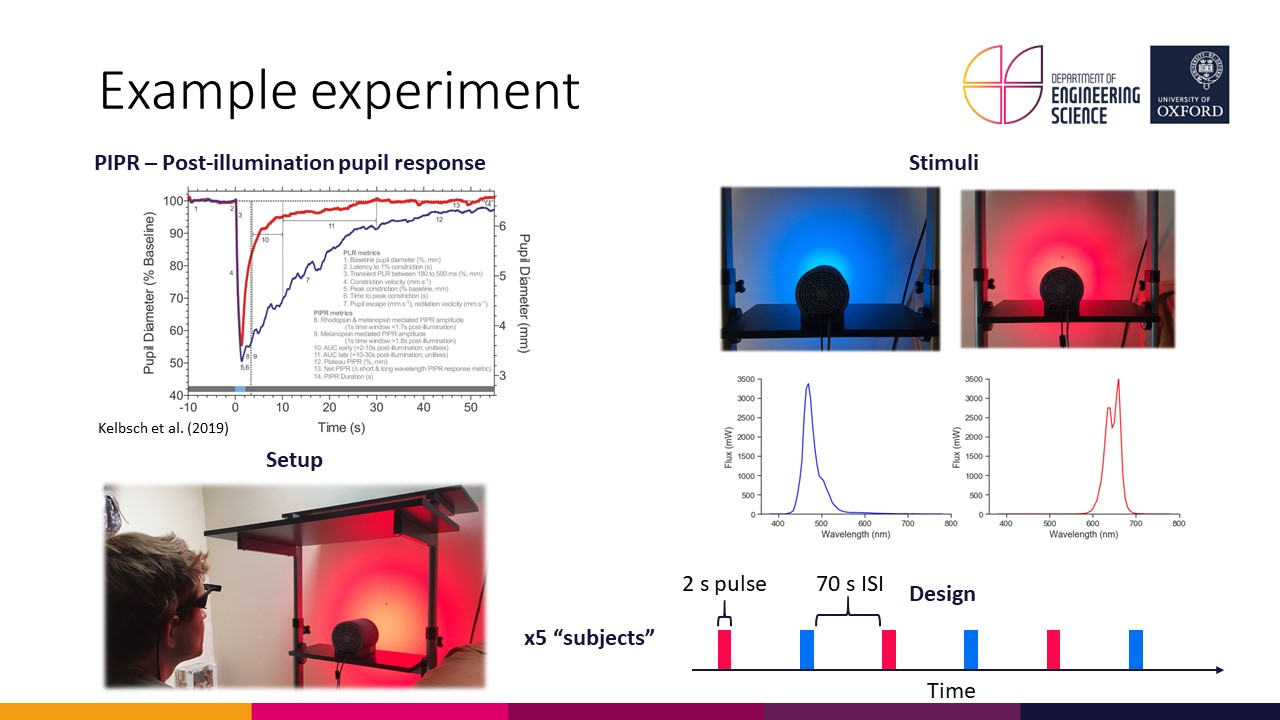

In [3]:
import os
import os.path as op

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import HDFStore

import pyplr as plr

sns.set_context(context="paper", font_scale=2.1)

Image("../../../data/red_vs_blue_2s_pulse_3trials_each/example_pipr_exp.jpg", width=1000)

### **Analysis pipeline**
For this example the analysis pipeline will follow the steps outlined below. Note that these steps are either idiosyncratic, non-essential or based on common standards in the pupillometry literature. They may not be appropriate for all data sets. 

0. Make a store for processed data
1. Initialize subject analysis
2. Load samples, events and blinks
3. Setup figure to plot data at subsequent stages of processing
4. Interpolate zeros (in case there is any signal dropout that is not blink-related)
5. Interpolate blinks
6. Smooth out high frequency noise (e.g. with butterworth or savitsky-golay filter)
7. Select events to extract
8. Extract events and their baselines
19. Apply baseline correction
10. Markup / reject bad trials based on a threshold of interpolated data (i.e. get rid of trials with unacceptably high blink rate)
11. Calculate averages for conditions
12. Plot extracted, baseline-corrected and averaged data
13. Calculate desired PLR / PIPR metrics from averages for each condition

### **Setting up the analysis**
To get started with the analysis, the first thing we need to do is export the pupil data from **Pupil Player**. This can be done by dropping the recordings into Pupil Player and pressing 'e', or clicking the 'export' button. This will create a subfolder within the recording directory called 'exports' and another numbered subfolder within exports that contains the exported data. There is also a community-developed batch-export method that may be able to assist with exporting multiple data files together. Once we've exported all of the data and gathered our subjects in a single directory, we need the path to that directory and a list of the individual subject directories. We also need to define the columns to load from the pupil data and the pupil columns we want to analyse, as well as some other useful constants. 

In [4]:
# directories for analysis
expdir = r"C:\Users\engs2242\Documents\cvd_pupillometry\data\red_vs_blue_2s_pulse_3trials_each"
subjdirs = [op.join(expdir, s) for s in os.listdir(expdir) if s.startswith("sub")]
grpdir = expdir + "\group"
if not op.isdir(grpdir):
    os.mkdir(grpdir)

# columns to load and analyse (just add more if needed!)
load_cols  =  ["pupil_timestamp","diameter","diameter_3d"]
pupil_cols = ["diameter","diameter_3d"]

# some parameters specific to this data set
SAMPLE_RATE = 120
DURATION    = 7200
ONSET_IDX   = 600

Now, with everything set up, let's loop over all the subject directories and perform our operations. Note that the code below saves some plots, along with some other output, for each subject in a folder called "analysis". The processed data for all subjects is additionally saved in a **HDFStore**. 

In [10]:
# 0. Make a store for processed data
processed = HDFStore(grpdir + '\\processed.h5')

for subjdir in subjdirs:
    
    # 1. initialize subject analysis
    s = plr.init_subject_analysis(subjdir, out_dir_nm="analysis")

    # 2. Load the samples, events and blinks (can use Pupil Labs blink detector or the Hershman algorithm)
    samples = plr.load_pupil(s["pl_data_dir"], cols=load_cols)
    events  = plr.load_annotations(s["pl_data_dir"])
    blinks  = plr.load_blinks(s["pl_data_dir"])
    #blinks = based_noise_blinks_detection(samples["diameter"], SAMPLE_RATE)

    # 3. Setup figure to plot data at subsequent stages of processing (optional)
    f, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14,14))

    # plot the raw data
    samples[pupil_cols].plot(title="Raw", ax=axs[0], legend=False)

    # 4. Interpolate zeros
    samples = plr.interpolate_zeros(samples, fields=pupil_cols)
    samples[pupil_cols].plot(title="Zeros interpolated", ax=axs[1], legend=False)

    # 5. Interpolate blinks
    samples = plr.interpolate_blinks(samples, blinks, fields=pupil_cols)
    samples[pupil_cols].plot(title="Blinks interpolated", ax=axs[2], legend=False)

    # 6. Smooth out high-frequency noise
    #samples = plr.savgol_series(samples, fields=pupil_cols, window_length=51, filt_order=7)
    samples = plr.butterworth_series(samples, fields=pupil_cols, filt_order=3, cutoff_freq=.05)
    samples[pupil_cols].plot(title="Butterworth filtered", ax=axs[3], legend=False)

    for ax in axs:
        ax.set_ylabel("Pupil diameter")    
        ax.set_xlabel("Pupil timestamp")
    axs[0].legend(loc="upper right", labels=["pixels", "mm"])
    f.tight_layout()
    f.savefig(s["out_dir"] + "\\" + s["id"] + "_pupil_processing.png")
    plt.close(f)
    
    # 7. Select events to extract
    events = events.query("label=='light_on'")
    events.index = events["timestamp"]

    # 8. Extract events and their baselines
    ranges    = plr.extract(samples, events, offset=-ONSET_IDX, duration=DURATION, 
                            borrow_attributes=["color"])
    baselines = plr.extract(samples, events, offset=-ONSET_IDX, duration=ONSET_IDX,
                            borrow_attributes=["color"]).mean(level=0)

    # 9. Apply baseline correction - here we do subtractive and divise baseline correction for both the 2d and 3d data
    ranges["diameter_pc"]   = (ranges.diameter / baselines.diameter - 1).values * 100
    ranges["diameter_3dpc"] = (ranges.diameter_3d / baselines.diameter_3d - 1).values * 100
    ranges["diameter_m"]    = (ranges.diameter - baselines.diameter)
    ranges["diameter_3dm"]  = (ranges.diameter_3d - baselines.diameter_3d)

    # 10. Markup / reject bad trials based on a threshold of interpolated data (i.e. get rid of trials with unacceptably high blink rate)
    ranges = plr.reject_bad_trials(ranges, interp_thresh=20, drop=False)

    # 11. Calculate averages for conditions
    averages = ranges.reset_index().groupby(by=["color", "onset"], as_index=True).mean()

    # 12. Plot extracted, baseline-corrected and averaged data (optional)
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

    # plot extracted trials
    ranges.reset_index(inplace=True)
    sns.lineplot(x="onset", y="diameter_3d", data=ranges, units="event", 
                 hue="color", estimator=None, palette=["red","blue"],
                 ax=axs[0], legend=False)
    axs[0].set_ylabel("Pupil diameter (mm)")
    axs[0].set_ylim((2, 8))
    axs[0].set_title("Extracted")

    # plot baseline corrected trials
    sns.lineplot(x="onset", y="diameter_3dm", data=ranges, units="event", 
             hue="color", estimator=None, palette=["red","blue"],
             ax=axs[1], legend=False)
    axs[1].set_title("Baseline-corrected")

    # plot averages
    axs[2].plot(averages.loc['red', "diameter_3dm"], color='red')
    axs[2].plot(averages.loc['blue', "diameter_3dm"], color='blue')
    axs[2].set_title("Averaged")

    for ax in axs:
        ax.set_xlabel("Time (s)")
        ax.set_xticks(range(ONSET_IDX, DURATION + SAMPLE_RATE, SAMPLE_RATE * 10))
        ax.set_xticklabels([str(xtl) for xtl in range(0, 65, 10)])
        ax.axvspan(ONSET_IDX, ONSET_IDX + (SAMPLE_RATE * 2), 0, 1, color='k', alpha=.2) 

    for ax in axs[1:]:
        ax.set_ylabel("Pupil modulation (mm)") 
        ax.hlines(0, 0, 7600, color='k', ls=':', lw=1.5)
        ax.set_ylim((-4, 2))

    f.tight_layout()
    f.savefig(s["out_dir"] + "\\" + s["id"] + "_extract_average.png")
    plt.close(f)
    
    # 13. Calculate desired PLR / PIPR metrics from averages for each condition
    # latency to 5% constriction
    PC = .05
    
    metrics = pd.DataFrame()
    clrs    = ["red", "blue"]
    for c in clrs:
        m = plr.plr_metrics(averages.loc[c, "diameter_3d"], SAMPLE_RATE, ONSET_IDX, PC)
        metrics = metrics.append(m.T)
    metrics.index = clrs
    
    # 14. Save the data
    # add the subject id
    ranges["subjid"] = s["id"]

    # append processed data to HDFStore
    processed.put(s["id"], ranges, format="table")
    
    # save metrics
    metrics.to_csv(s["out_dir"] + "\\" + s["id"] + "_PLR_metrics.csv")

#close store
processed.close()

************************************************************
***************************sub001***************************
************************************************************
Loaded 52952 samples
Loaded 12 events
18 blinks detected by Pupil Labs, average duration 0.233 s
517 samples (0.976 %) reconstructed with linear interpolation
Extracted ranges for 6 events
Extracted ranges for 6 events
Percentage of data interpolated for each trial (mean = 1.09): 
        interpolated
event              
0          0.680556
1          0.597222
2          0.958333
3          1.555556
4          2.500000
5          0.250000
0 trials were marked for rejection
************************************************************
***************************sub002***************************
************************************************************
Loaded 54134 samples
Loaded 12 events
14 blinks detected by Pupil Labs, average duration 0.231 s
399 samples (0.737 %) reconstructed with linear interpolati

Pyplr is programmed to print out some basic info about the analysis for each subject. Now, let's look at the plots that were created for the final subject.

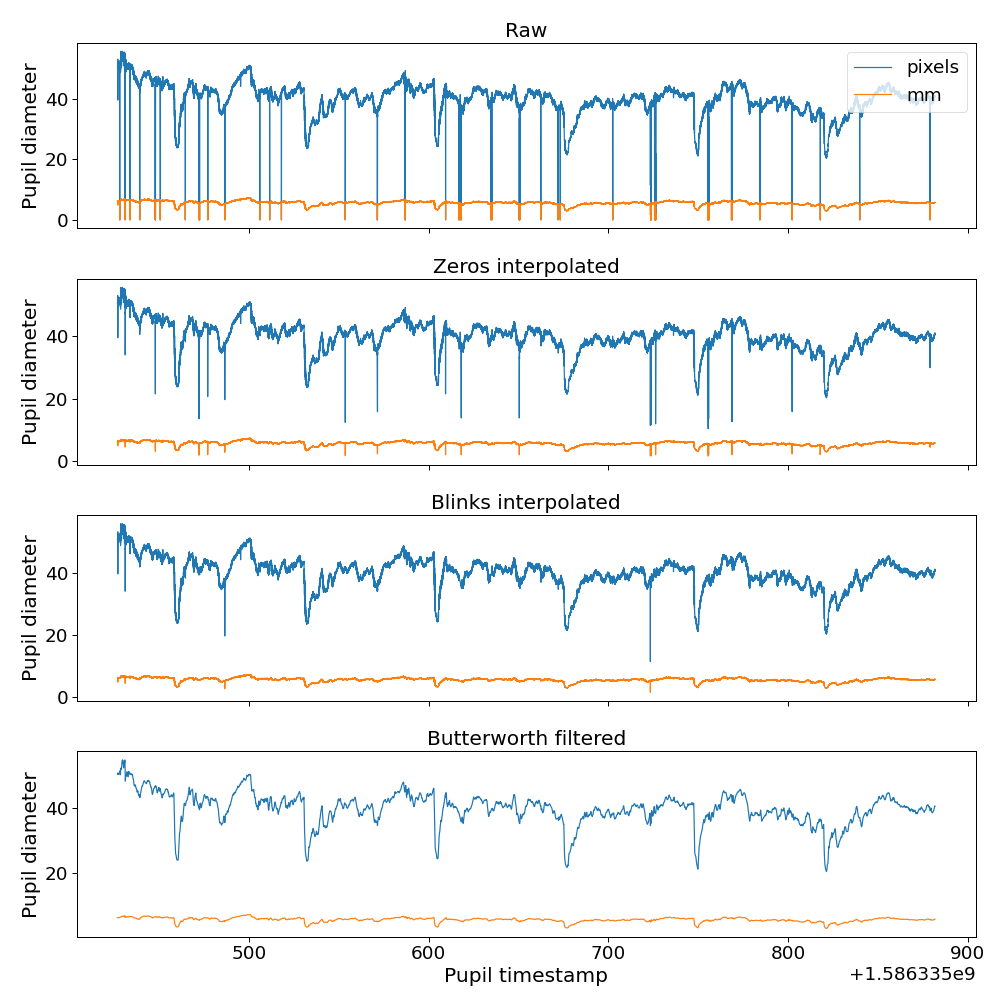

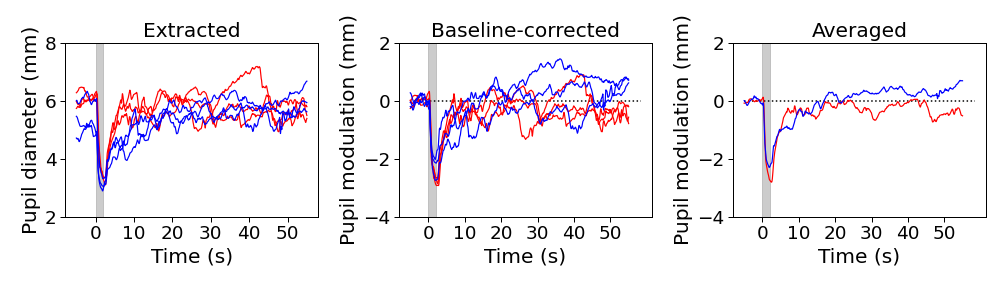

,red,blue
D1,6.079200,5.389522
T1,466.666667,358.333333
T2,633.333333,450.000000
T3,2516.666667,1891.666667
D2,3.276623,3.095354
AMP,2.802578,2.294168
VelConMax,4.964971,4.986172
VelConAve,1.211165,1.319834
AccConMax,17.217340,32.355259
CT,2050.000000,1533.333333


In [8]:
# show only the plots and metrics from the final subject
from IPython.display import Image, display
x = Image(filename=s["out_dir"] + "\\" + s["id"] + "_pupil_processing.png") 
y = Image(filename=s["out_dir"] + "\\" + s["id"] + "_extract_average.png") 
display(x, y)
metrics.T

After having performed the single-subject analysis we can move onto to looking at the data for the group. 

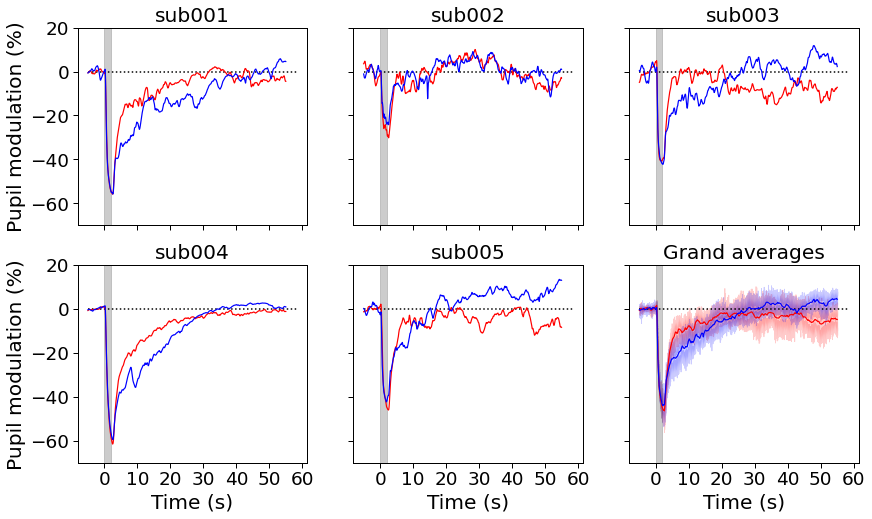

In [14]:
# 0. Re-open the store of processed data
processed.open()

# 1. Combine all of the processed data in a single DataFrame
combined = pd.DataFrame()
for subjdir in subjdirs:
    subject = subjdir[-6:]
    ranges = pd.read_hdf(processed, key=subject)
    #ranges["subject"] = subject
    combined = combined.append(ranges)
combined.reset_index(inplace=True)

# 2. Plot individual subject averages and grand-averages  
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(14,8))
axs = [item for sublist in axs for item in sublist]
p = 0
for sub, df in combined.groupby('subjid'):
    averages = df.groupby(by=["color","onset"], as_index=True).mean()

    axs[p].plot(averages.loc['red', "diameter_3dpc"], color='red')
    axs[p].plot(averages.loc['blue', "diameter_3dpc"], color='blue')
    axs[p].set_title(sub)
    p+=1
sns.lineplot(x="onset", y="diameter_3dpc", hue='color', data=combined,
             n_boot=10, ci=95, palette=['red','blue'], ax=axs[p], legend=False)

for ax in axs[3:]:
    ax.set_xlabel("Time (s)")
    
for ax in [axs[0], axs[3]]:
    ax.set_ylabel("Pupil modulation (%)")

for ax in axs:
    ax.set_xticks(range(600, 8400, 1200))
    ax.set_xticklabels([str(xtl) for xtl in range(0, 65, 10)])
    ax.axvspan(600, 840, 0, 1,color='k', alpha=.2) 
    ax.hlines(0, 0, 7600, color='k', ls=':', lw=1.5)
    ax.set_ylim((-70, 20))
axs[-1].set_title("Grand averages");

Looks like we have PLRs but no obvious PIPRs, which is hardly surprising as the testing conditions were not ideal (e.g. sat beneath a window in daylight on a sunny day). Another point to note is that the PLR latency metrics seem too long. This is because I used the STLAB in synchronous mode, where commands take a short while to execute (~100-200 ms). What we really need is to use the STLAB in asynchronous mode and use the WorldCam to timestamp the light stimuli.